In [84]:
# from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import xgboost as xgb 
#for some reason it refuses to recognize OpenMP

%matplotlib inline


XGBoostError: XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed (vcomp140.dll or libgomp-1.dll for Windows, libomp.dylib for Mac OSX, libgomp.so for Linux and other UNIX-like OSes). Mac OSX users: Run `brew install libomp` to install OpenMP runtime.
  * You are running 32-bit Python on a 64-bit OS
Error message(s): ['dlopen(/Users/juliervaughn/anaconda/lib/python3.5/site-packages/xgboost/lib/libxgboost.dylib, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib\n  Referenced from: /Users/juliervaughn/anaconda/lib/python3.5/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: image not found']


In [2]:
#Dataset is from https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008
dataset_path = "./dataset_diabetes/diabetic_data.csv"
df = pd.read_csv(dataset_path)

In [12]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [5]:
df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [6]:
#Map admission type ID to actual admission 
id_path = "./dataset_diabetes/IDs_mapping.csv"
id_map = pd.read_csv(id_path)

In [7]:
id_map[:5]

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available


In [14]:
df.race.value_counts()

Caucasian          76099
AfricanAmerican    19210
?                   2273
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64

In [16]:
df.gender.value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

In [18]:
df.age.value_counts()

[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64

In [20]:
pd.crosstab(index = df['gender'], columns =  df['race'])

race,?,AfricanAmerican,Asian,Caucasian,Hispanic,Other
gender,,,,,,
Female,1133,11728,318,39689,1092,748
Male,1138,7482,323,36410,945,757
Unknown/Invalid,2,0,0,0,0,1


In [67]:
pd.crosstab(columns = df['gender'], index =  [df['race'], df['age']])

gender                    Female   Male  Unknown/Invalid
race            age                                     
?               [0-10)         1      0                0
                [10-20)        3      6                0
                [20-30)       37      9                0
                [30-40)       43     33                0
                [40-50)       93    127                0
                [50-60)      161    200                0
                [60-70)      218    276                1
                [70-80)      306    292                1
                [80-90)      231    166                0
                [90-100)      40     29                0
AfricanAmerican [0-10)         8      8                0
                [10-20)      130     79                0
                [20-30)      376    164                0
                [30-40)      750    473                0
                [40-50)     1547   1240                0
                [50-60)     2457   1768                0
                [60-70)     2429   1803                0
                [70-80)     2450   1366                0
                [80-90)     1307    510                0
                [90-100)     274     71                0
Asian           [0-10)         1      1                0
                [10-20)        2      0                0
                [20-30)        5      1                0
                [30-40)       11      4                0
                [40-50)       24     28                0
                [50-60)       45     78                0
                [60-70)       78     82                0
                [70-80)       87     93                0
                [80-90)       60     30                0
                [90-100)       5      6                0
Caucasian       [0-10)        71     65                0
                [10-20)      249    189                0
                [20-30)      643    332                0
                [30-40)     1211    992                0
                [40-50)     2927   3204                0
                [50-60)     5559   6276                0
                [60-70)     7893   8800                0
                [70-80)    10754  10007                0
                [80-90)     8729   5873                0
                [90-100)    1653    672                0
Hispanic        [0-10)         2      0                0
                [10-20)       14      9                0
                [20-30)       41     22                0
                [30-40)       96     78                0
                [40-50)      154    183                0
                [50-60)      218    185                0
                [60-70)      253    236                0
                [70-80)      216    170                0
                [80-90)       85     56                0
                [90-100)      13      6                0
Other           [0-10)         0      4                0
                [10-20)        4      6                0
                [20-30)       12     15                0
                [30-40)       51     33                0
                [40-50)       66     92                0
                [50-60)      132    177                0
                [60-70)      190    224                0
                [70-80)      172    153                1
                [80-90)      103     47                0
                [90-100)      18      6                0

In [25]:
df.readmitted.value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1316d37f0>]],
      dtype=object)

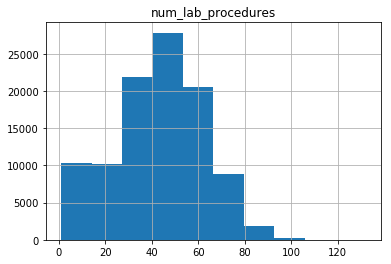

In [22]:
df.hist(column = 'num_lab_procedures')

In [42]:
#visualize categorical counts of intersectional identities (race + age)
ag = df.groupby('age').race.value_counts().sort_index()

age       race           
[0-10)    ?                      1
          AfricanAmerican       16
          Asian                  2
          Caucasian            136
          Hispanic               2
          Other                  4
[10-20)   ?                      9
          AfricanAmerican      209
          Asian                  2
          Caucasian            438
          Hispanic              23
          Other                 10
[20-30)   ?                     46
          AfricanAmerican      540
          Asian                  6
          Caucasian            975
          Hispanic              63
          Other                 27
[30-40)   ?                     76
          AfricanAmerican     1223
          Asian                 15
          Caucasian           2203
          Hispanic             174
          Other                 84
[40-50)   ?                    220
          AfricanAmerican     2787
          Asian                 52
          Caucasian          

In [47]:
flattened = ag.unstack() #dataframe from flattening multi-index object
flattened

Index(['?', 'AfricanAmerican', 'Asian', 'Caucasian', 'Hispanic', 'Other'], dtype='object', name='race')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x13916d470>],
      dtype=object)

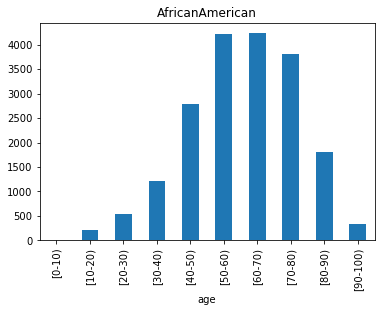

In [57]:
race = 'AfricanAmerican' #show age distribution for this race
flattened[race].plot(kind = 'bar', subplots = True)
#African American patients skew slightly younger in this dataset

In [74]:
#See https://www.kaggle.com/brandao/diabetes for descriptions
df.columns #55 total columns, let's just work with relevant/non-missing data

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

Dropping the following features: 
- Missingness: weight, payer code, medical specialty
- Simplifying: medication features (24 specific medication names)

In [78]:
diabetes_rel = df[['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
    'change', 'diabetesMed', 'readmitted']]

In [79]:
diabetes_rel 

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,...,0,250.83,?,?,1,None,None,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,0,276,250.01,255,9,None,None,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,1,648,250,V27,6,None,None,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,0,8,250.43,403,7,None,None,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,0,197,157,250,5,None,None,Ch,Yes,NO
5,35754,82637451,Caucasian,Male,[50-60),2,1,2,3,31,...,0,414,411,250,9,None,None,No,Yes,>30
6,55842,84259809,Caucasian,Male,[60-70),3,1,2,4,70,...,0,414,411,V45,7,None,None,Ch,Yes,NO
7,63768,114882984,Caucasian,Male,[70-80),1,1,7,5,73,...,0,428,492,250,8,None,None,No,Yes,>30
8,12522,48330783,Caucasian,Female,[80-90),2,1,4,13,68,...,0,398,427,38,8,None,None,Ch,Yes,NO
9,15738,63555939,Caucasian,Female,[90-100),3,3,4,12,33,...,0,434,198,486,8,None,None,Ch,Yes,NO


In [81]:
#now we need to pre-process, convert nomial variables to one-hot encoding and then split into train and test sets
diabetes_rel['A1Cresult']

0         None
1         None
2         None
3         None
4         None
5         None
6         None
7         None
8         None
9         None
10        None
11        None
12        None
13        None
14        None
15        None
16        None
17        None
18        None
19        None
20        None
21        None
22        None
23        None
24        None
25        None
26          >7
27        None
28        None
29        None
          ... 
101736    None
101737    None
101738    None
101739    None
101740    None
101741    None
101742      >8
101743    None
101744    None
101745      >8
101746    None
101747      >7
101748      >7
101749    Norm
101750    None
101751    Norm
101752    None
101753    None
101754      >7
101755      >8
101756    None
101757    None
101758    None
101759    None
101760    None
101761      >8
101762    None
101763    None
101764    None
101765    None
Name: A1Cresult, Length: 101766, dtype: object